In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('mapping_data.csv')

In [3]:
df.head(20)

,Opportunity Record Type,Account Name,Type,Close Date,Mailing City,POSTALCODE,PROVINCE,Product Family,Product Name,Quantity,Cubic Volume Total (Ft),In Kind Value (Tax Receipt Value),DAY,MONTH,YEAR
0,In-Kind - Pick Up,Donor 1,In Kind Donation,13/08/2018,Toronto,M6A 1Y7,ON,Living Room,End Table,3.0,139.7,$150.00,13,8,2018
1,In-Kind - Pick Up,Donor 1,In Kind Donation,13/08/2018,Toronto,M6A 1Y7,ON,Office Furniture,Desk,1.0,139.7,$100.00,13,8,2018
2,In-Kind - Pick Up,Donor 1,In Kind Donation,13/08/2018,Toronto,M6A 1Y7,ON,Living Room,Occasional Chair,1.0,139.7,$50.00,13,8,2018
3,In-Kind - Pick Up,Donor 1,In Kind Donation,13/08/2018,Toronto,M6A 1Y7,ON,Bedroom Furniture,Night Table,1.0,139.7,$50.00,13,8,2018
4,In-Kind - Pick Up,Donor 1,In Kind Donation,13/08/2018,Toronto,M6A 1Y7,ON,Dining / Kitchen Furniture,Buffet and Hutch,1.0,139.7,$150.00,13,8,2018
5,In-Kind - Pick Up,Donor 1,In Kind Donation,13/08/2018,Toronto,M6A 1Y7,ON,Housewares & Linens,Housewares (per box),3.0,139.7,$75.00,13,8,2018
6,In-Kind - Pick Up,Donor 1,In Kind Donation,13/08/2018,Toronto,M6A 1Y7,ON,Art & Collectables,Picture (framed),1.0,139.7,$25.00,13,8,2018
7,In-Kind - Pick Up,Donor 1,In Kind Donation,13/08/2018,Toronto,M6A 1Y7,ON,Bedroom Furniture,Vanity,1.0,139.7,$150.00,13,8,2018
8,In-Kind - Pick Up,Donor 2,In Kind Donation,30/03/2019,Toronto,M6J 0A1,ON,Housewares & Linens,Linens (per bag),2.0,326.9,$50.00,30,3,2019
9,In-Kind - Pick Up,Donor 2,In Kind Donation,30/03/2019,Toronto,M6J 0A1,ON,Living Room,Armchair,2.0,326.9,$200.00,30,3,2019


In [4]:
df['Product Family'].value_counts()

Living Room                   22070
Bedroom Furniture             14763
Dining / Kitchen Furniture     9363
Housewares & Linens            6581
Electronics                    5316
Office Furniture               3126
Art & Collectables             2533
Small Appliances               1723
None                             18
Rugs, Carpets & Curtains          2
General Furniture                 1
Name: Product Family, dtype: int64

## Cleaning

In [5]:
df = df[df['Product Family'].isin(['Living Room', 'Bedroom Furniture', 'Dining / Kitchen Furniture', \
                             'Housewares & Linens', 'Electronics', 'Office Furniture', 'Art & Collectables'])]
# Label by month and year
df['month-year'] = df['MONTH'].astype(str) + '-' + df['YEAR'].astype(str) 

# Remove dollar sign from value and convert to float
df['value'] = df['In Kind Value (Tax Receipt Value)'].replace('[\$,]', '', regex=True).astype(float)

# Categorize donor or client
df['type'] = df['Account Name'].apply(lambda x : x.split(' ')[0])

# Calculate total volume of furniture
product_list = pd.read_csv('product_list.csv')
product_list = product_list[['Product Family','Product Name', 'CUBIC VOLUME (ft)']]
df = pd.merge(df, product_list, on=['Product Family','Product Name'], how='left')
df['Total Volume'] = df['Quantity'] * df['CUBIC VOLUME (ft)']

df.loc[df['Product Name'] == 'Television Stand', 'Product Family'] = 'Electronics/Appliances'
df.loc[df['Product Name'] == 'Futon -Complete', 'Product Family'] = 'Bedroom Furniture'
df.loc[df['Product Name'] == 'Mirror', 'Product Family'] = 'Bedroom Furniture'
df.loc[df['Product Name'] == 'Lamp -Floor', 'Product Family'] = 'Electronics/Appliances'
df.loc[df['Product Name'] == 'Lamp -Table', 'Product Family'] = 'Electronics/Appliances'
df.loc[df['Product Name'] == 'Microwave', 'Product Family'] = 'Electronics/Appliances'

# Recategorize furniture
# Bedroom Furniture
# Queen Bed: [Queen Bed Frame, Queen Boxspring, Queen Mattress, Queen Bed - Complete]
# Twin Bed: [Twin Bed Frame, Twin Boxspring, Twin Mattress, Twin Bed - Complete]
# Single Bed: [Single Bed Frame, Single Boxspring, Single Mattress, Single Bed - Complete]
# Double Bed: [Double Bed Frame, Double Boxspring, Double Mattress, Double Bed - Complete]
# Other Bed: [King Mattress, Bunk Bed, Captains Bed Frame, Folding Bed / Cot]
# Wardrobe: [Armoire, Wardrobe]
# Dresser: ['Chest of Drawers', 'Dresser', 'Dresser with mirror', 'Night Table', 'Vanity', "Mirror"]
bedroom_furniture = df[df['Product Family'] == "Bedroom Furniture"]
bedroom_furniture = bedroom_furniture.replace({
 'Queen Bed Frame': 'Queen Bed', 'Queen Boxspring': 'Queen Bed', 'Queen Mattress': 'Queen Bed', 'Queen Bed - Complete': 'Queen Bed',\
 'Twin Bed Frame': 'Twin Bed', 'Twin Boxspring': 'Twin Bed', 'Twin Mattress': 'Twin Bed', 'Twin Bed - Complete': 'Twin Bed',\
 'Single Bed Frame': 'Single Bed', 'Single Boxspring': 'Single Bed', 'Single Mattress': 'Single Bed', 'Single Bed - Complete': 'Single Bed',\
 'Double Bed Frame': 'Double Bed', 'Double Boxspring': 'Double Bed', 'DoubleMattress': 'Double Bed', 'Double Bed - Complete': 'Double Bed',\
 'King Mattress': 'Other Bed', 'Double Mattress': 'Double Bed', 'Bunk Bed': 'Other Bed', 'Captains Bed Frame': 'Other Bed', 'Folding Bed / Cot': 'Other Bed',\
 'Armoire': 'Wardrobe', 'Chest of Drawers': 'Dresser/Drawer', 'Chest of Drawers (DRESSER)': 'Dresser/Drawer', 'Dresser with mirror': 'Dresser/Drawer', 'Night Table': 'Dresser/Drawer', 'Vanity': 'Dresser/Drawer',\
 'Twin SSHORE New Mattress': 'Twin Bed', 'Queen ENDY New Mattress': 'Queen Bed', 'Queen SSHORE New Mattress': 'Queen Bed', 'Double - SSHORE New Mattress': 'Double Bed', 'Double - ENDY New Mattress': 'Double Bed',\
 'Chest': 'Dresser/Drawer', 'Trunk': 'Dresser/Drawer', 'Dresser': 'Dresser/Drawer', 'Futon -Complete': 'Other Bed'})

# Living room
# Upholstered Chairs/Couch: [Armchair, Lazy Boy chair, Club Chair, Wing chair, Rocking Chair, Recliner, Ottoman]
# Small Chairs: [Bar Stool, Bench, Easy chair, Occasional Chair]
# Sofa: [Sofa, Sofa -Luxury, Sofabed, Sofabed Mattress, Loveseat, Sectional Sofa]
# Shelfs: [Book Shelf -Large, Book Shelf -Small, CD Stand]
# Cabinets: [Cabinet, Chest, Sideboard]
# Tables: [Coffee Table, End Table, Side Table, Nesting Table Set]
# Lamps: [Lamp -Floor, Lamp -Table]
# Wall Unit: [Entertainment Unit, Wall Unit]
# Discard: [Futon -Complete, Single - Mattress Encasement]
living_room = df[df['Product Family'] == "Living Room"]
living_room = living_room.replace({
    'Armchair': 'Upholstered Chair', 'Lazy Boy chair': 'Upholstered Chair', 'Club Chair' : 'Upholstered Chair', \
    'Wing chair': 'Upholstered Chair', 'Rocking Chair': 'Upholstered Chair', 'Recliner': 'Upholstered Chair', 'Ottoman': 'Upholstered Chair', \
    'Bar Stool': 'Small Chair', 'Bench': 'Small Chair', 'Easy chair': 'Small Chair', 'Occasional Chair': 'Small Chair', \
    'Book Shelf -Large': 'Shelf', 'Book Shelf -Small': 'Shelf', 'CD Stand': 'Shelf', 'Chest': 'Cabinet', 'Sideboard': 'Cabinet', \
    'Coffee Table': 'Table', 'End Table': 'Table', 'Side Table': 'Table', 'Nesting Table Set': 'Table', 'Entertainment Unit': 'Wall Unit',\
    'Sofa -Luxury': 'Sofa', 'Sofabed': 'Sofa', 'Sofabed Mattress': 'Sofa', 'Sofabed': 'Sofa', 'Loveseat': 'Sofa', 'Sectional Sofa': 'Sofa'})

# Electronics/Appliances:
# Television: [Television -Tube, Television Stand, Televison -Large Flat Screen (more than 32), Televison -Small Flat Screen (less than 32)]
# Computer: [Computer, Computer Monitor, 'Computer Monitor -Small (less than 21)]
# Stereos: [Stereo Speaker, Stereo (Record Player)]
# Bar Fridge: [Bar Fridge, Minibar Fridge]
electronics = df[df['Product Family'] == "Electronics"]
small_appliances = df[df['Product Family'] == "Small Appliances"]
electronics = electronics.replace({'Electronics': 'Electronics/Appliances'})
small_appliances = small_appliances.replace({'Small Appliances': 'Electronics/Appliances'})
electronics_appliances = pd.concat([electronics, small_appliances])
electronics_appliances = electronics_appliances.replace({
    'Television -Tube': 'Television', 'Television Stand': 'Television', 'Televison -Large Flat Screen (more than 32)': 'Television', 'Televison -Small Flat Screen (less than 32)': 'Television',\
    'Computer Monitor': 'Computer', 'Computer Monitor -Small (less than 21)': 'Computer', 'Laptop': 'Computer',\
    'Stereo Speaker': 'Other', 'Stereo (Record Player)': 'Other', 'Minibar Fridge': 'Bar Fridge', 'DVD/VCR Player': 'Other', 'Vacuum cleaner': 'Other',\
    'Lamp -Floor': 'Lamp', 'Lamp -Table': 'Lamp'})

# Dining / Kitchen Furniture
# Cupboards/Shelfs: [Shelf -Large, Shelf -Small, Buffet and Hutch, Kitchen Cupboard / Microwave Stand]
# Chairs: [Dining Chair, Folding Chair, Kitchen Chair, Stepstool, Stool]
# Tables: [Dining Table, Folding Table, Kitchen Table]
# kitchen items (box)
dining = df[df['Product Family'] == "Dining / Kitchen Furniture"]
dining = dining.replace({
    'Shelf -Large': 'Shelf', 'Shelf -Small': 'Shelf', 'Kitchen Cupboard / Microwave Stand': 'Shelf',\
    'Buffet and Hutch': 'Sideboard', 'Credenza': 'Sideboard', 'Dining Chair': 'Chair', 'Folding Chair': 'Chair', 'Kitchen Chair': 'Chair', 'Stepstool': 'Chair', 'Stool': 'Chair', 'Bar Stool': 'Chair',\
    'Dining Table': 'Table', 'Folding Table': 'Table', 'Kitchen Table': 'Table'})

# Office furniture
# Chairs: [Chair, upholstered, Computer Chair, Office Chair]
# Tables: [Computer Table, Desk, Desk-large]
# Cabinets: [Filing Cabinet -Large, Filing Cabinet -Small, Credenza]
office_furniture = df[df['Product Family'] == "Office Furniture"]
office_furniture = office_furniture.replace({
    'Chair, upholstered': 'Chair', 'Computer Chair': 'Chair', 'Office Chair': 'Chair', 'Computer Table': 'Desk', 'Desk-large': 'Desk',\
    'Filing Cabinet -Large': 'Cabinet', 'Filing Cabinet -Small': 'Cabinet', 'Credenza': 'Cabinet'})

# Rugs, Carpets & Curtains
# Rug: [Rug, Throw rugs]
# Cabinets: [Filing Cabinet -Large, Filing Cabinet -Small, Credenza]
rugs = df[df['Product Family'] == "Rugs, Carpets & Curtains"]
rugs = rugs.replace({'Throw rugs': 'Rug'})
                       
# Replace all of Art & Collectables as Pictures/Paintings/Plants
art = df[df['Product Family'] == "Art & Collectables"]
art = art.replace({'Artificial Plant / Christmas Tree': 'Art & Collectables', 'Painting': 'Art & Collectables', 'Picture': 'Art & Collectables', 'Picture (framed)': 'Art & Collectables'})

# Replace all of Housewares & Linens as Housewares & Linens
linens = df[df['Product Family'] == "Housewares & Linens"]
linens['Product Name'] = 'Housewares & Linens'

df = pd.concat([bedroom_furniture, living_room, electronics_appliances, dining, office_furniture, rugs, art, linens])

/Users/dianaow/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## Data Exploration

#### Number of unique clients

In [6]:
len(df[df['type'] == 'Client']['Account Name'].unique())

2175

#### Number of unique donors

In [7]:
len(df[df['type'] == 'Donor']['Account Name'].unique())

6714

#### Total valuation of donated furniture received by clients

In [8]:
df[df['type'] == 'Client']['value'].sum()

2720915.0

#### Total valuation of donated furniture

In [9]:
df[df['type'] == 'Donor']['value'].sum()

4592290.0

#### Total volume of donated furniture received by clients

In [10]:
df[df['type'] == 'Client']['Total Volume'].sum()

521389.66550925915

#### Total volume of donated furniture

In [11]:
df[df['type'] == 'Donor']['Total Volume'].sum()

913122.3043981481

### Volume of furniture per Product Family received by client over time

In [12]:
plt.figure(figsize=(15,8))
ax = sns.lineplot(x="month-year", y="Client", hue="Product Family", data=df_pt2)
ax.set(ylim=(0, 22000))

NameError: name 'df_pt2' is not defined

<Figure size 1080x576 with 0 Axes>

### Volume of furniture per Product Family given by donor over time

In [ ]:
plt.figure(figsize=(15,8))
ax = sns.lineplot(x="month-year", y="Donor", hue="Product Family", data=df_pt2)
ax.set(ylim=(0, 22000))

### Total excess (in volume) of furniture per Product Family

In [13]:
df_pt = pd.pivot_table(df, columns='type', index='Product Family', values='Total Volume', aggfunc=np.sum).reset_index()
df_pt['diff'] = ((df_pt['Donor'] - df_pt['Client'])/df_pt['Donor']) * 100
df_pt.sort_values('diff', ascending=True)

type,Product Family,Client,Donor,diff
1,Bedroom Furniture,158597.687500,227944.125000,30.422560
2,Dining / Kitchen Furniture,137648.916667,220466.170139,37.564608
5,Living Room,181546.603009,337737.356481,46.246218
6,Office Furniture,21120.574074,40619.009259,48.003227
0,Art & Collectables,2023.939815,4865.425926,58.401590
3,Electronics/Appliances,1258.138889,3107.675926,59.515119
4,Housewares & Linens,19193.805556,78382.541667,75.512652


### Total excess (in volume) of donated furniture per Product Name

In [14]:
df_pt = pd.pivot_table(df, columns='type', index='Product Name', values='Total Volume', aggfunc=np.sum).reset_index()
df_pt['diff'] = ((df_pt['Donor'] - df_pt['Client'])/df_pt['Donor']) * 100
df_pt.sort_values('diff', ascending=True)

type,Product Name,Client,Donor,diff
11,Queen Bed,57766.666667,66466.666667,13.089268
5,Double Bed,17620.312500,20503.125000,14.060357
6,Dresser/Drawer,50566.250000,67443.041667,25.023770
8,Mirror,510.666667,692.000000,26.204239
2,Chair,63794.768519,95781.012731,33.395183
19,Table,85311.722222,132755.500000,35.737712
17,Small Chair,12913.593750,20385.208333,36.652137
22,Upholstered Chair,46053.166667,77187.833333,40.336236
3,Computer,10.555556,19.444444,45.714286
15,Sideboard,11800.000000,21850.000000,45.995423


### Excess (in volume) of donated furniture per Product Family over time

In [15]:
df_pt2 = pd.pivot_table(df, columns='type', index=['month-year','Product Family'], values='Total Volume', aggfunc=np.sum, fill_value=0).reset_index()
df_pt2['month-year'] = df_pt2['month-year'].apply(lambda x: datetime.strptime(x, '%m-%Y'))
df_pt2 = df_pt2[df_pt2['month-year'] >= datetime(year=2017,month=10,day=1)]
df_pt2 = df_pt2.sort_values(['Product Family', 'month-year'], ascending=True).reset_index(drop=True)
df_pt2['diff'] = df_pt2['Donor'] - df_pt2['Client']
df_pt2_cumsum = df_pt2[['Product Family', 'month-year', 'diff']].groupby(by=['Product Family', 'month-year'])\
.sum().groupby(level=[0]).cumsum().reset_index()

/Users/dianaow/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


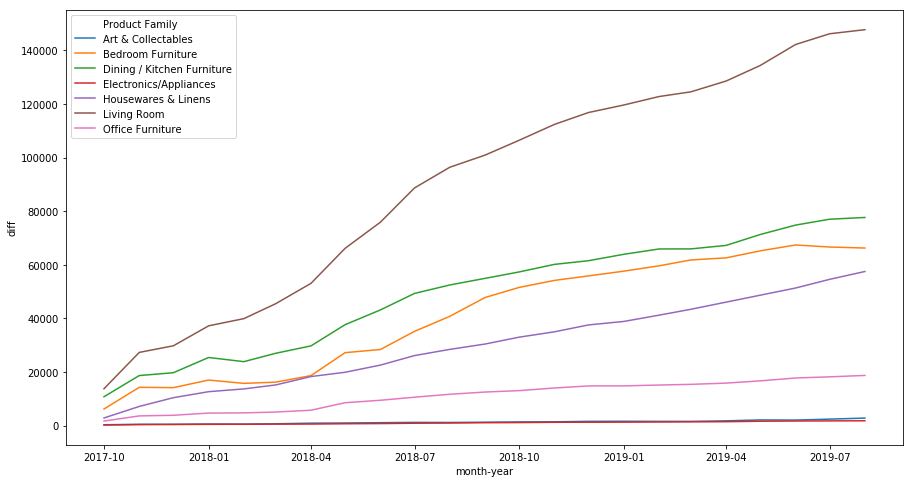

In [16]:
plt.figure(figsize=(15,8))
ax = sns.lineplot(x="month-year", y="diff", hue="Product Family", data= df_pt2_cumsum)

### Excess (in volume) of donated furniture per Product Name over time

In [17]:
df_pt3 = pd.pivot_table(df, columns='type', index=['month-year','Product Family', 'Product Name'], values='Total Volume', aggfunc=np.sum).reset_index()
df_pt3['month-year'] = df_pt3['month-year'].apply(lambda x: datetime.strptime(x, '%m-%Y'))
df_pt3 = df_pt3[df_pt3['month-year'] >= datetime(year=2017,month=10,day=1)]
df_pt3 = df_pt3.sort_values(['Product Family', 'Product Name', 'month-year'], ascending=True).reset_index(drop=True)
df_pt3['Client'] = df_pt3['Client'].fillna(0)
df_pt3['Donor'] = df_pt3['Donor'].fillna(0)
df_pt3['diff'] = df_pt3['Donor'] - df_pt3['Client']
df_pt3['diff'] = df_pt3['diff'].fillna(0)


In [18]:
# There is a bug with this statement. Generated cumulated results are not accurate
#df_pt3_cumsum = df_pt3[['Product Family', 'Product Name', 'month-year', 'diff']].groupby(by=['Product Family', 'Product Name',  'month-year'])\
#.sum().groupby(level=[1]).cumsum().reset_index()

# Workaround is to individually calculate cumulated volume
OF = df_pt3[df_pt3['Product Family'] == 'Office Furniture'][['Product Family', 'Product Name', 'month-year', 'diff']].groupby(by=['Product Family', 'Product Name',  'month-year'])\
.sum().groupby(level=[1]).cumsum().reset_index()

LR = df_pt3[df_pt3['Product Family'] == 'Living Room'][['Product Family', 'Product Name', 'month-year', 'diff']].groupby(by=['Product Family', 'Product Name',  'month-year'])\
.sum().groupby(level=[1]).cumsum().reset_index()

H = df_pt3[df_pt3['Product Family'] == 'Housewares & Linens'][['Product Family', 'Product Name', 'month-year', 'diff']].groupby(by=['Product Family', 'Product Name',  'month-year'])\
.sum().groupby(level=[1]).cumsum().reset_index()

E = df_pt3[df_pt3['Product Family'] == 'Electronics/Appliances'][['Product Family', 'Product Name', 'month-year', 'diff']].groupby(by=['Product Family', 'Product Name',  'month-year'])\
.sum().groupby(level=[1]).cumsum().reset_index()

K = df_pt3[df_pt3['Product Family'] == 'Dining / Kitchen Furniture'][['Product Family', 'Product Name', 'month-year', 'diff']].groupby(by=['Product Family', 'Product Name',  'month-year'])\
.sum().groupby(level=[1]).cumsum().reset_index()

BR = df_pt3[df_pt3['Product Family'] == 'Bedroom Furniture'][['Product Family', 'Product Name', 'month-year', 'diff']].groupby(by=['Product Family', 'Product Name',  'month-year'])\
.sum().groupby(level=[1]).cumsum().reset_index()

A = df_pt3[df_pt3['Product Family'] == 'Art & Collectables'][['Product Family', 'Product Name', 'month-year', 'diff']].groupby(by=['Product Family', 'Product Name',  'month-year'])\
.sum().groupby(level=[1]).cumsum().reset_index()

df_pt3_cumsum = pd.concat([OF, LR, H, E, K, BR, A])
df_pt3_cumsum.to_csv('/Users/dianaow/Documents/react_apps/cumsum_data.csv')

In [19]:
df_pt3_donor = df_pt3.drop(columns=['diff', 'Client']).rename(columns={'Donor': 'Volume'})
df_pt3_donor['type'] = 'Donor'
df_pt3_client = df_pt3.drop(columns=['diff', 'Donor']).rename(columns={'Client': 'Volume'})
df_pt3_client['type'] = 'Client'
df_pt3_1 = pd.concat([df_pt3_donor, df_pt3_client])

#### Excess (in volume) of donated Bedroom Furniture

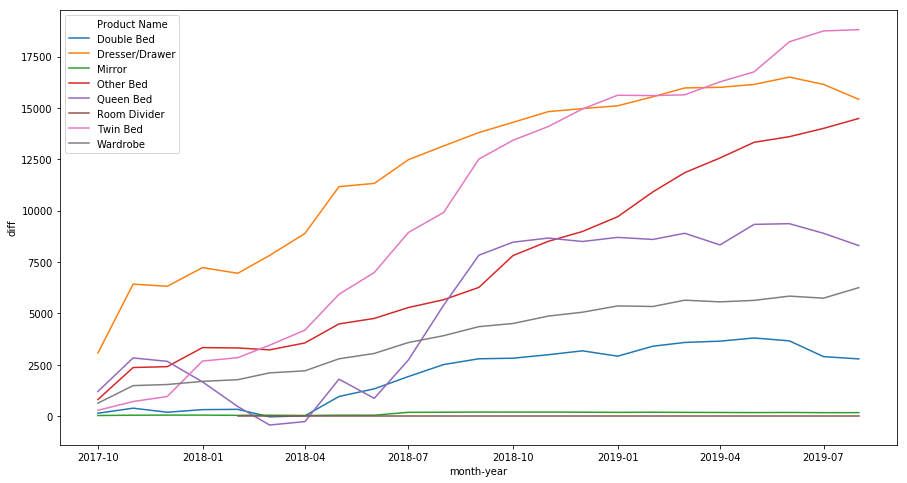

In [20]:
plt.figure(figsize=(15,8))
ax = sns.lineplot(x="month-year", y="diff", hue="Product Name", data=BR)

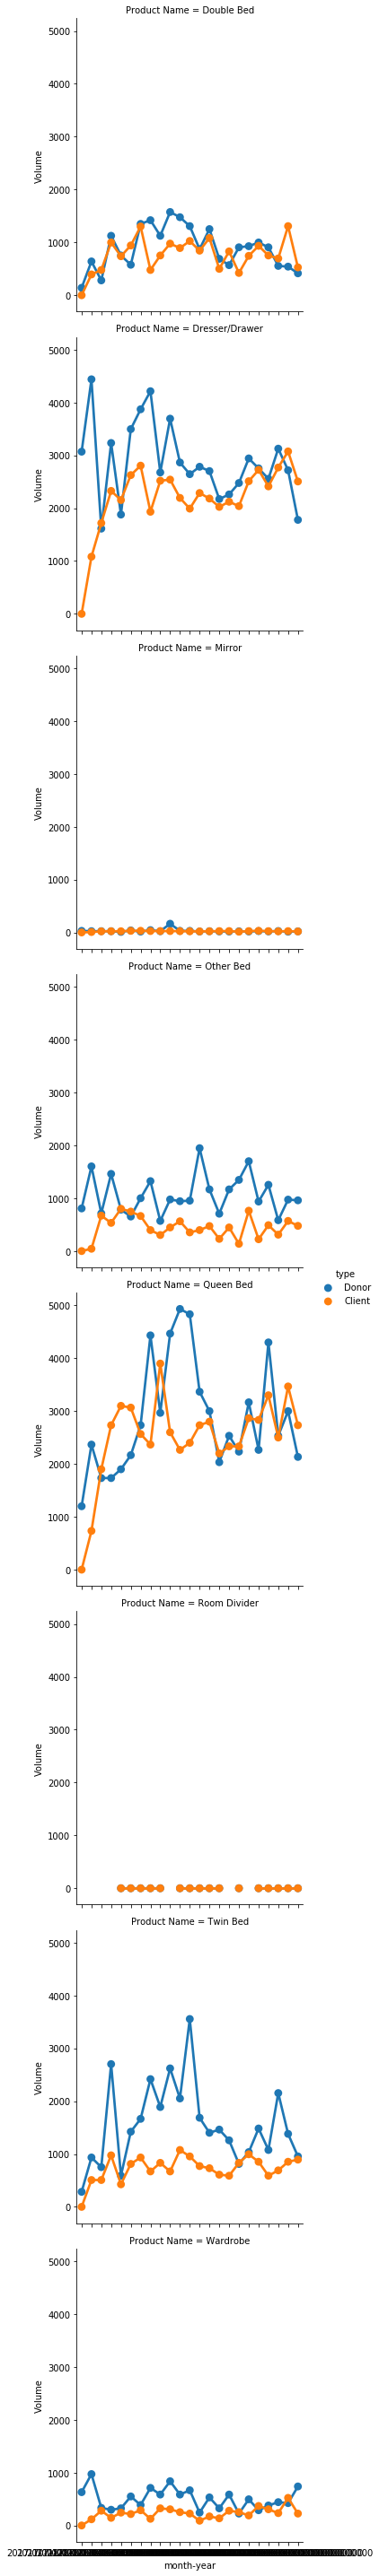

In [21]:
ax = sns.catplot(x="month-year", y="Volume", row="Product Name", hue='type', kind='point',\
                  data= df_pt3_1[df_pt3_1['Product Family'] == 'Bedroom Furniture'])

#### Excess (in volume) of donated Living Room Furniture

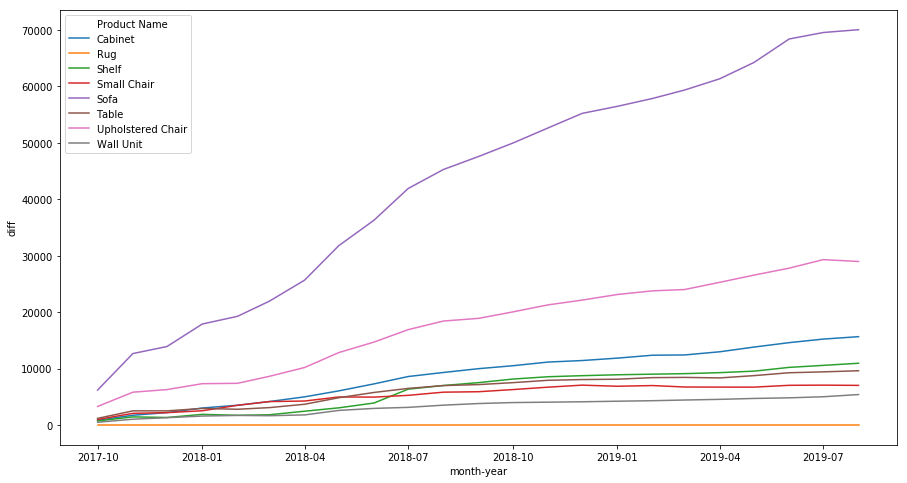

In [22]:
plt.figure(figsize=(15,8))
ax = sns.lineplot(x="month-year", y="diff", hue="Product Name", data=LR)

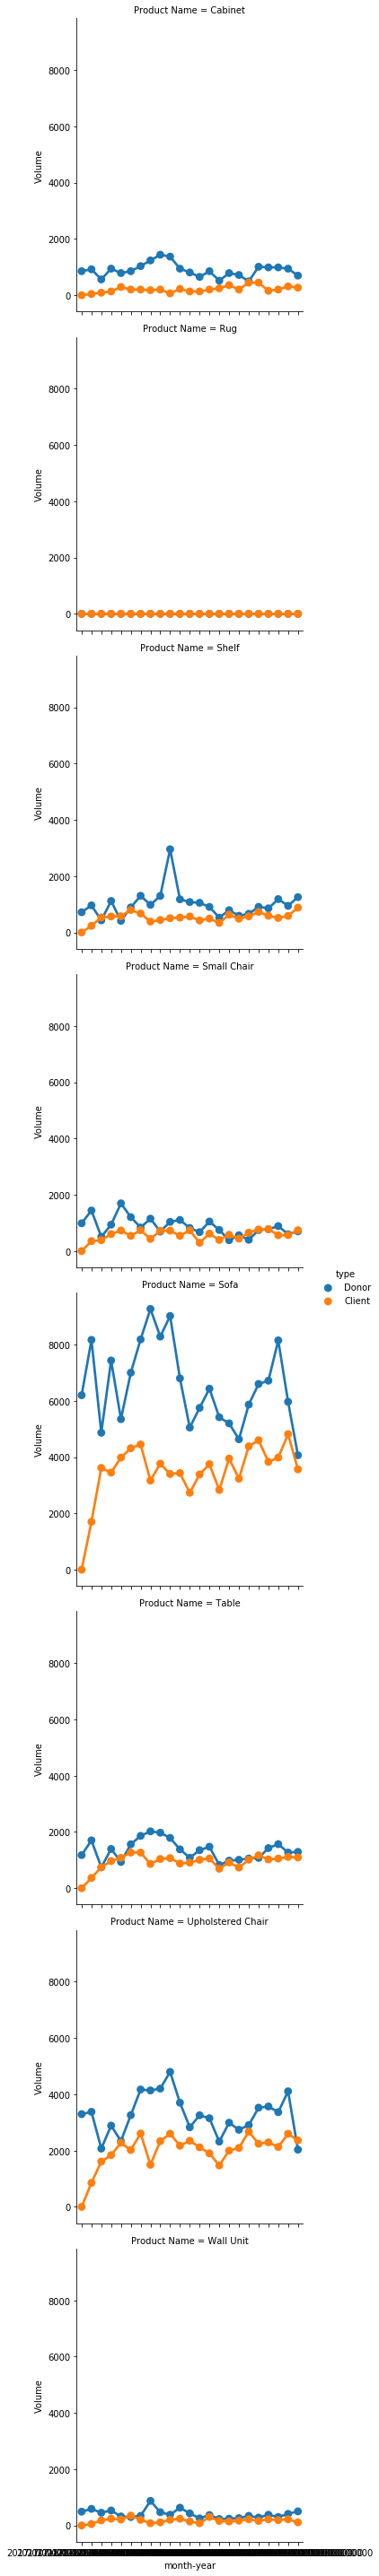

In [23]:
ax = sns.catplot(x="month-year", y="Volume", row="Product Name", hue='type', kind='point',\
                  data= df_pt3_1[df_pt3_1['Product Family'] == 'Living Room'])

#### Excess (in volume) of donated Office Furniture

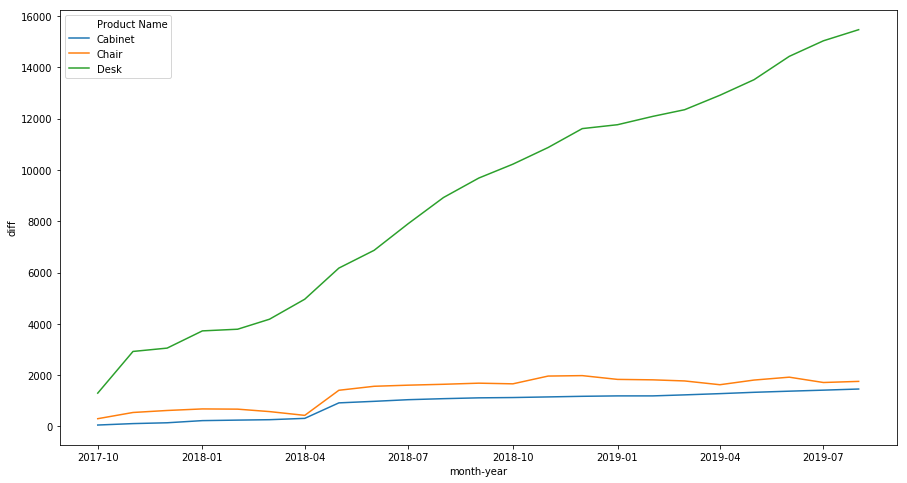

In [24]:
plt.figure(figsize=(15,8))
ax = sns.lineplot(x="month-year", y="diff", hue="Product Name", data=OF)

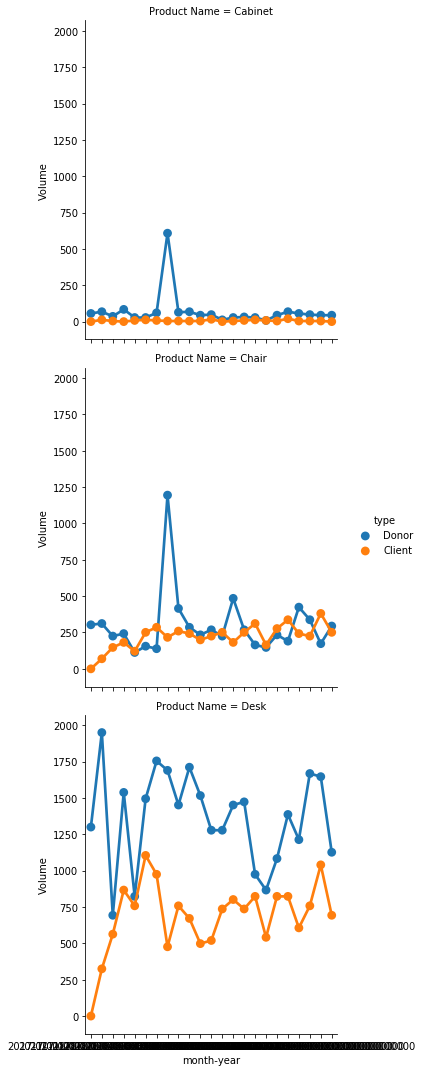

In [25]:
ax = sns.catplot(x="month-year", y="Volume", row="Product Name", hue='type', kind='point',\
                  data= df_pt3_1[df_pt3_1['Product Family'] == 'Office Furniture'])

#### Excess (in volume) of donated Dining/Kitchen Furniture

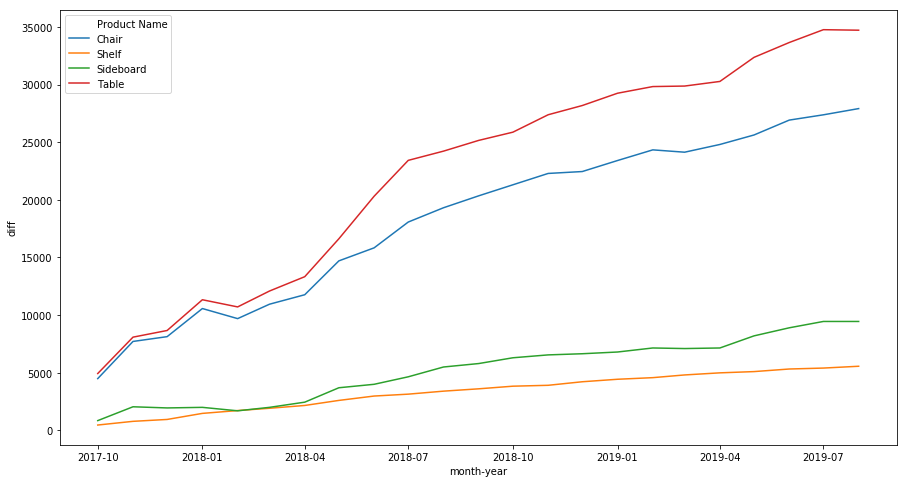

In [26]:
plt.figure(figsize=(15,8))
ax = sns.lineplot(x="month-year", y="diff", hue="Product Name", data= K)

In [53]:
K

,Product Family,Product Name,month-year,diff
0,Dining / Kitchen Furniture,Chair,2017-10-01,4493.923611
1,Dining / Kitchen Furniture,Chair,2017-11-01,7716.406250
2,Dining / Kitchen Furniture,Chair,2017-12-01,8132.118056
3,Dining / Kitchen Furniture,Chair,2018-01-01,10570.486111
4,Dining / Kitchen Furniture,Chair,2018-02-01,9695.833333
5,Dining / Kitchen Furniture,Chair,2018-03-01,10946.093750
6,Dining / Kitchen Furniture,Chair,2018-04-01,11767.881944
7,Dining / Kitchen Furniture,Chair,2018-05-01,14704.774306
8,Dining / Kitchen Furniture,Chair,2018-06-01,15835.069444
9,Dining / Kitchen Furniture,Chair,2018-07-01,18072.916667


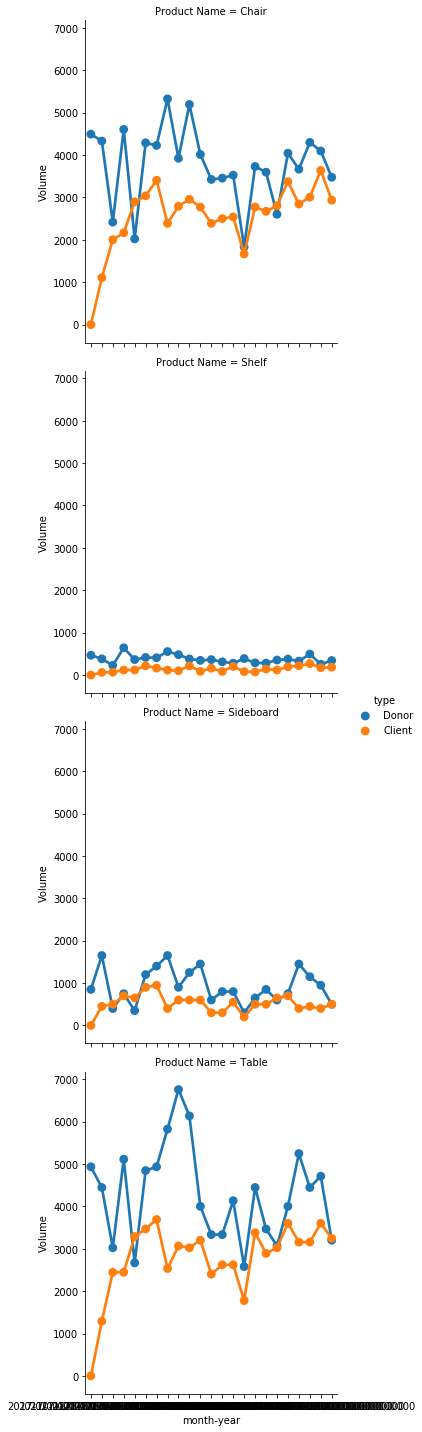

In [27]:
ax = sns.catplot(x="month-year", y="Volume", row="Product Name", hue='type', kind='point',\
                  data= df_pt3_1[df_pt3_1['Product Family'] == 'Dining / Kitchen Furniture'])

#### Excess (in volume) of donated Electronics/Appliances

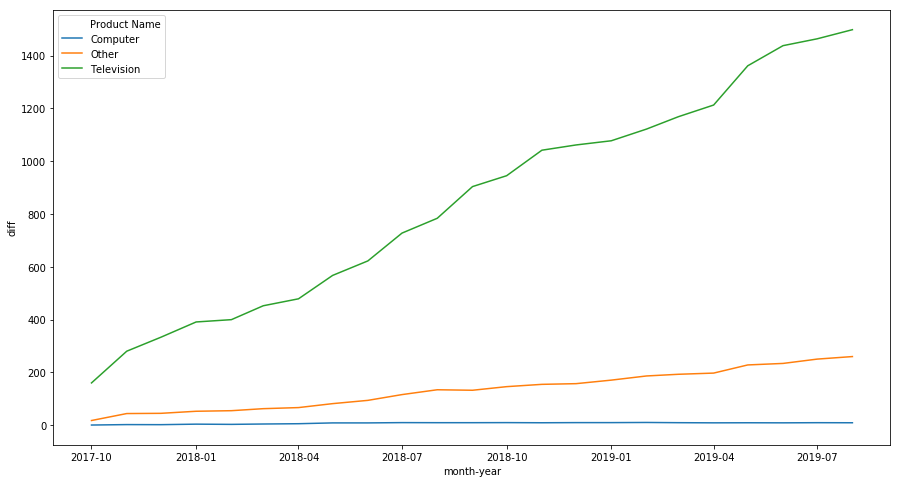

In [28]:
plt.figure(figsize=(15,8))
ax = sns.lineplot(x="month-year", y="diff", hue="Product Name", data= E)

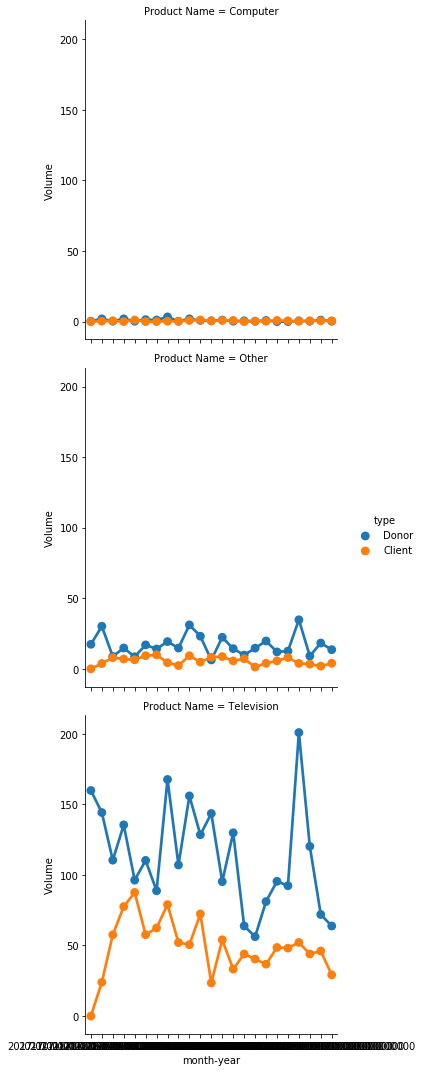

In [29]:
ax = sns.catplot(x="month-year", y="Volume", row="Product Name", hue='type', kind='point',\
                  data= df_pt3_1[df_pt3_1['Product Family'] == 'Electronics/Appliances'])

### Explore combinations of furniture donated and recieved

In [30]:
id_grp = pd.DataFrame(df.groupby(['type', 'Account Name', 'Product Family', 'Product Name'])['Quantity'].sum()).reset_index()

In [31]:
id_grp

,type,Account Name,Product Family,Product Name,Quantity
0,Client,Client 1,Bedroom Furniture,Double Bed,3.0
1,Client,Client 1,Bedroom Furniture,Dresser/Drawer,2.0
2,Client,Client 1,Dining / Kitchen Furniture,Chair,2.0
3,Client,Client 1,Dining / Kitchen Furniture,Shelf,1.0
4,Client,Client 1,Dining / Kitchen Furniture,Table,1.0
5,Client,Client 1,Housewares & Linens,Housewares & Linens,2.0
6,Client,Client 1,Living Room,Sofa,1.0
7,Client,Client 1,Living Room,Table,1.0
8,Client,Client 10,Art & Collectables,Art & Collectables,2.0
9,Client,Client 10,Bedroom Furniture,Dresser/Drawer,1.0


In [32]:
pd.pivot_table(df, columns='Product Name', index=['Account Name'], values='Quantity').reset_index()

Product Name,Account Name,Art & Collectables,Cabinet,Chair,Computer,Desk,Double Bed,Dresser/Drawer,Housewares & Linens,Mirror,...,Sideboard,Single Bed,Small Chair,Sofa,Table,Television,Twin Bed,Upholstered Chair,Wall Unit,Wardrobe
0,Client 1,NaN,NaN,2.000000,NaN,NaN,1.0,1.000000,1.000000,NaN,...,NaN,NaN,NaN,1.0,1.000000,NaN,NaN,NaN,NaN,NaN
1,Client 10,2.0,NaN,2.500000,NaN,1.0,NaN,1.000000,2.000000,NaN,...,NaN,NaN,NaN,NaN,1.500000,NaN,NaN,1.0,NaN,NaN
2,Client 100,NaN,NaN,NaN,NaN,1.0,NaN,1.333333,NaN,1.0,...,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Client 1000,NaN,NaN,1.500000,NaN,NaN,NaN,1.000000,1.333333,1.0,...,NaN,NaN,NaN,1.0,1.000000,1.0,NaN,NaN,NaN,1.0
4,Client 1001,2.0,NaN,1.000000,NaN,1.0,NaN,1.500000,1.000000,1.0,...,1.0,NaN,1.0,1.0,2.000000,NaN,NaN,1.0,NaN,NaN
5,Client 1002,4.0,NaN,1.000000,NaN,1.0,1.0,1.000000,1.500000,NaN,...,NaN,NaN,1.0,1.0,1.000000,NaN,NaN,1.0,NaN,NaN
6,Client 1003,1.0,1.0,2.500000,NaN,1.0,NaN,1.000000,1.666667,1.0,...,NaN,NaN,NaN,1.0,1.000000,NaN,NaN,NaN,NaN,NaN
7,Client 1004,3.0,NaN,2.500000,NaN,1.0,NaN,1.000000,3.000000,NaN,...,NaN,NaN,NaN,1.0,1.333333,NaN,NaN,1.0,NaN,NaN
8,Client 1005,5.0,NaN,4.000000,NaN,NaN,NaN,1.000000,5.000000,1.0,...,1.0,NaN,1.0,1.0,1.000000,1.0,NaN,1.0,NaN,NaN
9,Client 1006,NaN,NaN,3.666667,NaN,1.0,1.0,1.000000,NaN,NaN,...,NaN,NaN,NaN,1.0,1.000000,NaN,NaN,1.0,NaN,NaN


## Data Transformation for Treemap

In [40]:
df_pt3_cumsum['month-year'] = df_pt3_cumsum['month-year'].apply(lambda x: datetime.strftime(x, '%m-%Y'))

In [48]:
df_treemap = pd.pivot_table(df_pt3_cumsum, index=['Product Family', 'Product Name'], columns=['month-year'],\
                        values='diff', aggfunc=np.sum, fill_value=0).reset_index()
arr_cols = ['Product Family', 'Product Name', '10-2017', '11-2017', '12-2017', '01-2018', '02-2018', '03-2018', \
            '04-2018', '05-2018','06-2018', '07-2018', '08-2018', '09-2018', '10-2018', '11-2018', '12-2018', '01-2019',\
            '02-2019', '03-2019', '04-2019', '05-2019', '06-2019', '07-2019', '08-2019']

df_treemap = df_treemap[arr_cols]

df_treemap.to_csv('/Users/dianaow/Documents/react_apps/mapping_data.csv')

In [49]:
df_treemap[df_treemap['Product Name'] == 'Queen Bed']

month-year,Product Family,Product Name,10-2017,11-2017,12-2017,01-2018,02-2018,03-2018,04-2018,05-2018,...,11-2018,12-2018,01-2019,02-2019,03-2019,04-2019,05-2019,06-2019,07-2019,08-2019
5,Bedroom Furniture,Queen Bed,1200.0,2833.333333,2666.666667,1666.666667,466.666667,-433.333333,-266.666667,1800.0,...,8666.666667,8500.0,8700.0,8600.0,8900.0,8333.333333,9333.333333,9366.666667,8900.0,8300.0


## Product List (Custom)

In [50]:
df_product_list = df_treemap[['Product Family', 'Product Name']]
df_product_list = df_product_list.drop_duplicates()
df_product_list.to_csv('/Users/dianaow/Documents/react_apps/df_product_list.csv')

In [51]:
df_product_list[df_product_list['Product Family'] == "Bedroom Furniture"].sort_values('Product Name', ascending=True)

month-year,Product Family,Product Name
1,Bedroom Furniture,Double Bed
2,Bedroom Furniture,Dresser/Drawer
3,Bedroom Furniture,Mirror
4,Bedroom Furniture,Other Bed
5,Bedroom Furniture,Queen Bed
6,Bedroom Furniture,Room Divider
7,Bedroom Furniture,Twin Bed
8,Bedroom Furniture,Wardrobe


In [52]:
df_product_list

month-year,Product Family,Product Name
0,Art & Collectables,Art & Collectables
1,Bedroom Furniture,Double Bed
2,Bedroom Furniture,Dresser/Drawer
3,Bedroom Furniture,Mirror
4,Bedroom Furniture,Other Bed
5,Bedroom Furniture,Queen Bed
6,Bedroom Furniture,Room Divider
7,Bedroom Furniture,Twin Bed
8,Bedroom Furniture,Wardrobe
9,Dining / Kitchen Furniture,Chair
